In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import bigrams

In [68]:
import json

def parse_data(file):
    for l in open(file, 'r'):
        yield json.loads(l)

data = list(parse_data('../data/Sarcasm_Headlines_Dataset_v2.json'))
df = pd.DataFrame(data)

In [3]:
df

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


## Understand the dataset

In [4]:
# overview
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
df['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

## Check for missing or duplicated data

In [7]:
df.isnull().sum() # no missing data

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [69]:
df.duplicated().sum() # two duplicated rows

np.int64(2)

In [70]:
df = df.drop_duplicates() # remove duplicated data

In [71]:
df.drop('article_link', axis = 1, inplace=True)

## Removing stop words and tokenization

In [72]:
translator = str.maketrans('', '', string.punctuation)
df['headline'] = df['headline'].astype(str).str.lower() # lowercase
df['headline'] = df['headline'].apply(lambda x: x.translate(translator)) # remove punctuations
df['token'] = df.apply(lambda row: word_tokenize(row['headline']), axis=1) # tokenization
stop_words = set(stopwords.words('english'))
df['word'] = df['token'].apply(lambda x: [word for word in x if word not in stop_words]) # remove stopwords
df['bigram'] = df['token'].apply(lambda x: list(bigrams(x))) # bigrams
df['bigram_remove'] = df['bigram'].apply(lambda x: [word for word in x if word[0] not in stop_words 
                                                    and word[1] not in stop_words]) # remove bigrams with stop words
df['bigram'] = df['bigram_remove'].apply(lambda x: [' '.join(word) for word in x])
df.drop('bigram_remove', axis=1, inplace=True)

In [73]:
df

,is_sarcastic,headline,token,word,bigram
0,1,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientists, unveil, doomsday...","[thirtysomething, scientists, unveil, doomsday...","[thirtysomething scientists, scientists unveil..."
1,0,dem rep totally nails why congress is falling ...,"[dem, rep, totally, nails, why, congress, is, ...","[dem, rep, totally, nails, congress, falling, ...","[dem rep, rep totally, totally nails, falling ..."
2,0,eat your veggies 9 deliciously different recipes,"[eat, your, veggies, 9, deliciously, different...","[eat, veggies, 9, deliciously, different, reci...","[veggies 9, 9 deliciously, deliciously differe..."
3,1,inclement weather prevents liar from getting t...,"[inclement, weather, prevents, liar, from, get...","[inclement, weather, prevents, liar, getting, ...","[inclement weather, weather prevents, prevents..."
4,1,mother comes pretty close to using word stream...,"[mother, comes, pretty, close, to, using, word...","[mother, comes, pretty, close, using, word, st...","[mother comes, comes pretty, pretty close, usi..."
...,...,...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,"[jews, to, celebrate, rosh, hashasha, or, some...","[jews, celebrate, rosh, hashasha, something]","[celebrate rosh, rosh hashasha]"
28615,1,internal affairs investigator disappointed con...,"[internal, affairs, investigator, disappointed...","[internal, affairs, investigator, disappointed...","[internal affairs, affairs investigator, inves..."
28616,0,the most beautiful acceptance speech this week...,"[the, most, beautiful, acceptance, speech, thi...","[beautiful, acceptance, speech, week, came, qu...","[beautiful acceptance, acceptance speech, week..."
28617,1,mars probe destroyed by orbiting spielberggate...,"[mars, probe, destroyed, by, orbiting, spielbe...","[mars, probe, destroyed, orbiting, spielbergga...","[mars probe, probe destroyed, orbiting spielbe..."


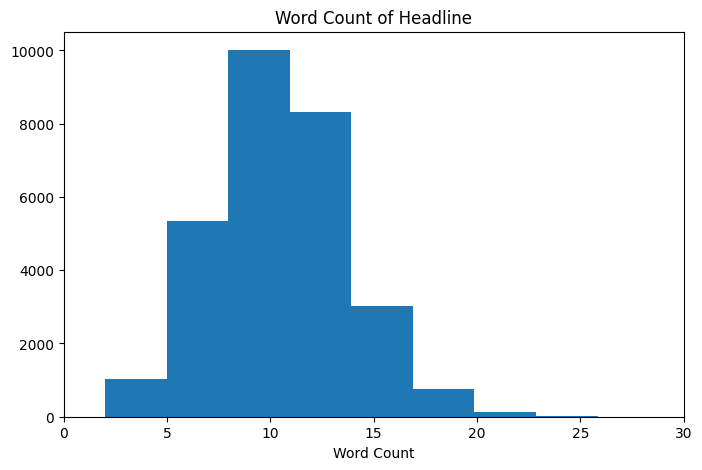

In [74]:
df['headline_word_count'] = df['headline'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
plt.hist(df['headline_word_count'], bins = 50)
plt.xlabel('Word Count')
plt.title('Word Count of Headline')
plt.xlim(0, 30)
plt.show()

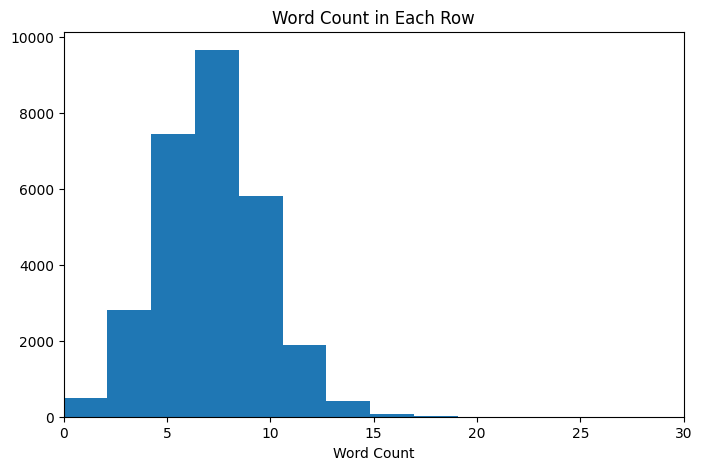

In [75]:
# word count of tokenized words after removing stop words
plt.figure(figsize=(8, 5))
plt.hist(df['word'].apply(len), bins = 50)
plt.xlabel('Word Count')
plt.title('Word Count in Each Row')
plt.xlim(0, 30)
plt.show()

In [76]:
# create a dataframe of words & counts
all_words = [word for i in df['word'] for word in i]
count = Counter(all_words)
word_count_df = pd.DataFrame(count.items(), columns = ['word', 'count'])
word_count_df = word_count_df.sort_values(by = 'count', ascending = False)

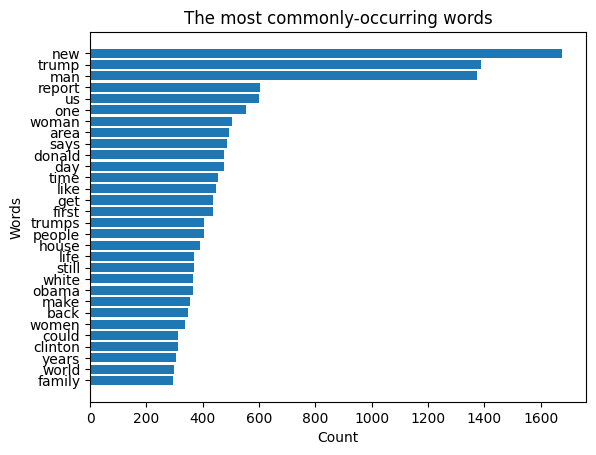

In [77]:
# the most commonly-occurring words
common_word = word_count_df[:30]
plt.barh(common_word['word'], common_word['count'])
plt.title("The most commonly-occurring words")
plt.xlabel("Count")
plt.ylabel("Words")
plt.gca().invert_yaxis()
plt.show()

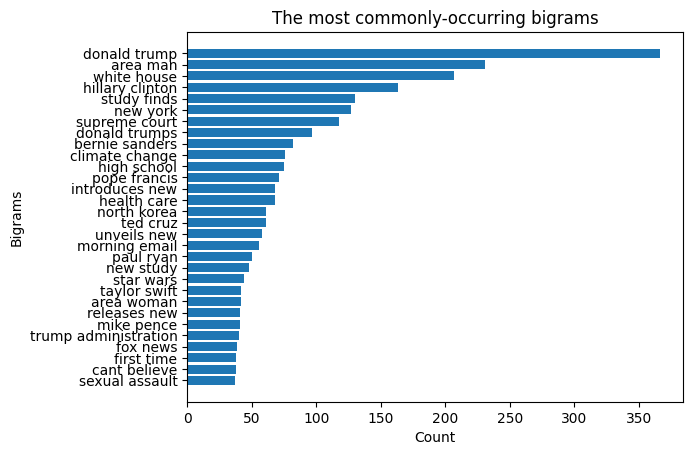

In [87]:
# create a dataframe of words & counts
all_bigrams = [bigram for i in df['bigram'] for bigram in i]
count_bigram = Counter(all_bigrams)
bigram_count_df = pd.DataFrame(count_bigram.items(), columns = ['bigram', 'count'])
bigram_count_df = bigram_count_df.sort_values(by = 'count', ascending = False)

# the most commonly-occurring bigrams
common_bigram = bigram_count_df[:30]
plt.barh(common_bigram['bigram'], common_bigram['count'])
plt.title("The most commonly-occurring bigrams")
plt.xlabel("Count")
plt.ylabel("Bigrams")
plt.gca().invert_yaxis()
plt.show()

In [78]:
# create a dataframe of words & count broken by is_sarcastic
words_1 = [] # sarcastic word
bigram_1 = [] # sarcastic bigram
words_0 = [] # not sarcastic
bigram_0 = [] # sarcastic bigram

for index, row in df.iterrows():
    if row['is_sarcastic'] == 1:
        for w in row['word']:
            words_1.append(w)
        for b in row['bigram']:
            bigram_1.append(b)
    elif row['is_sarcastic'] == 0:
        for w in row['word']:
            words_0.append(w)
        for b in row['bigram']:
            bigram_0.append(b)

count_1 = Counter(words_1)
words_1_df = pd.DataFrame(count_1.items(), columns = ['word', 'count'])
words_1_df = words_1_df.sort_values(by = 'count', ascending = False) # sarcastic word df
count_0 = Counter(words_0)
words_0_df = pd.DataFrame(count_0.items(), columns = ['word', 'count'])
words_0_df = words_0_df.sort_values(by = 'count', ascending = False) # not sarcastic word df

count_b_1 = Counter(bigram_1)
bigram_1_df = pd.DataFrame(count_b_1.items(), columns = ['bigram', 'count'])
bigram_1_df = bigram_1_df.sort_values(by = 'count', ascending = False) # sarcastic bigram df
count_b_0 = Counter(bigram_0)
bigram_0_df = pd.DataFrame(count_b_0.items(), columns = ['bigram', 'count'])
bigram_0_df = bigram_0_df.sort_values(by = 'count', ascending = False) # not sarcastic bigram df

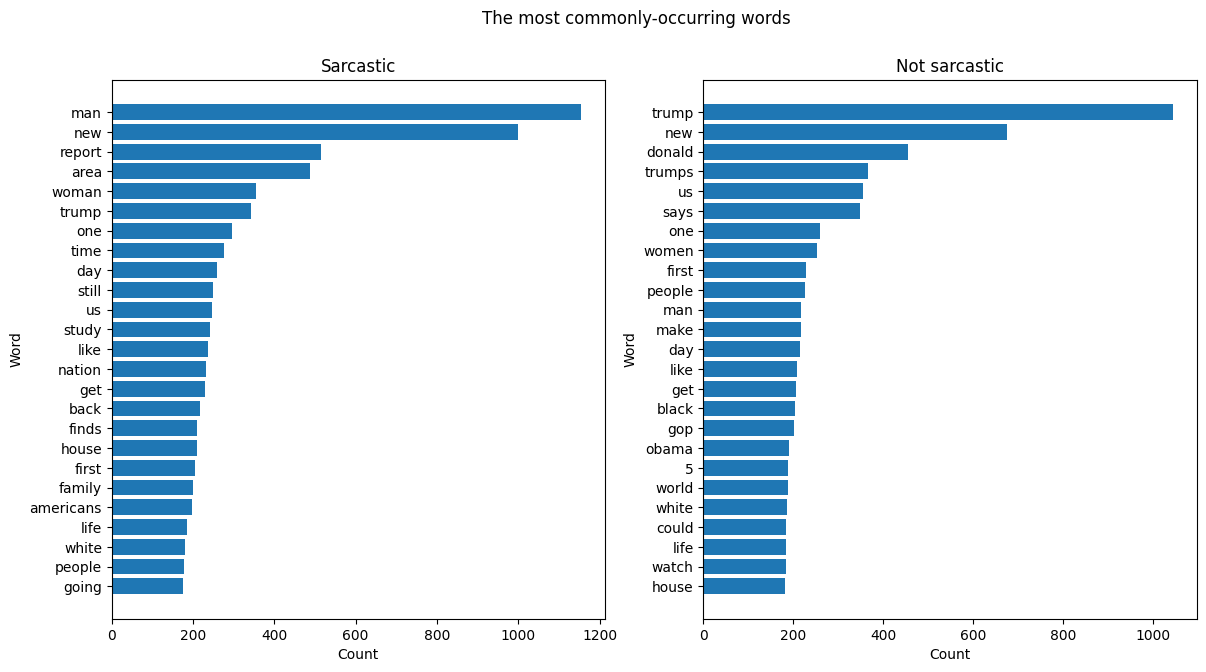

In [79]:
# the most commonly-occurring words, broken down by label
common_words_1 = words_1_df[:25]
common_words_0 = words_0_df[:25]
fig, axs = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(14)
axs[0].barh(common_words_1['word'], common_words_1['count']) # positive
axs[0].invert_yaxis()
axs[0].set_xlabel("Count")
axs[0].set_ylabel("Word")
axs[1].barh(common_words_0['word'], common_words_0['count']) # negative
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")
axs[1].set_ylabel("Word")
fig.suptitle("The most commonly-occurring words")
axs[0].title.set_text('Sarcastic')
axs[1].title.set_text('Not sarcastic')
plt.show()

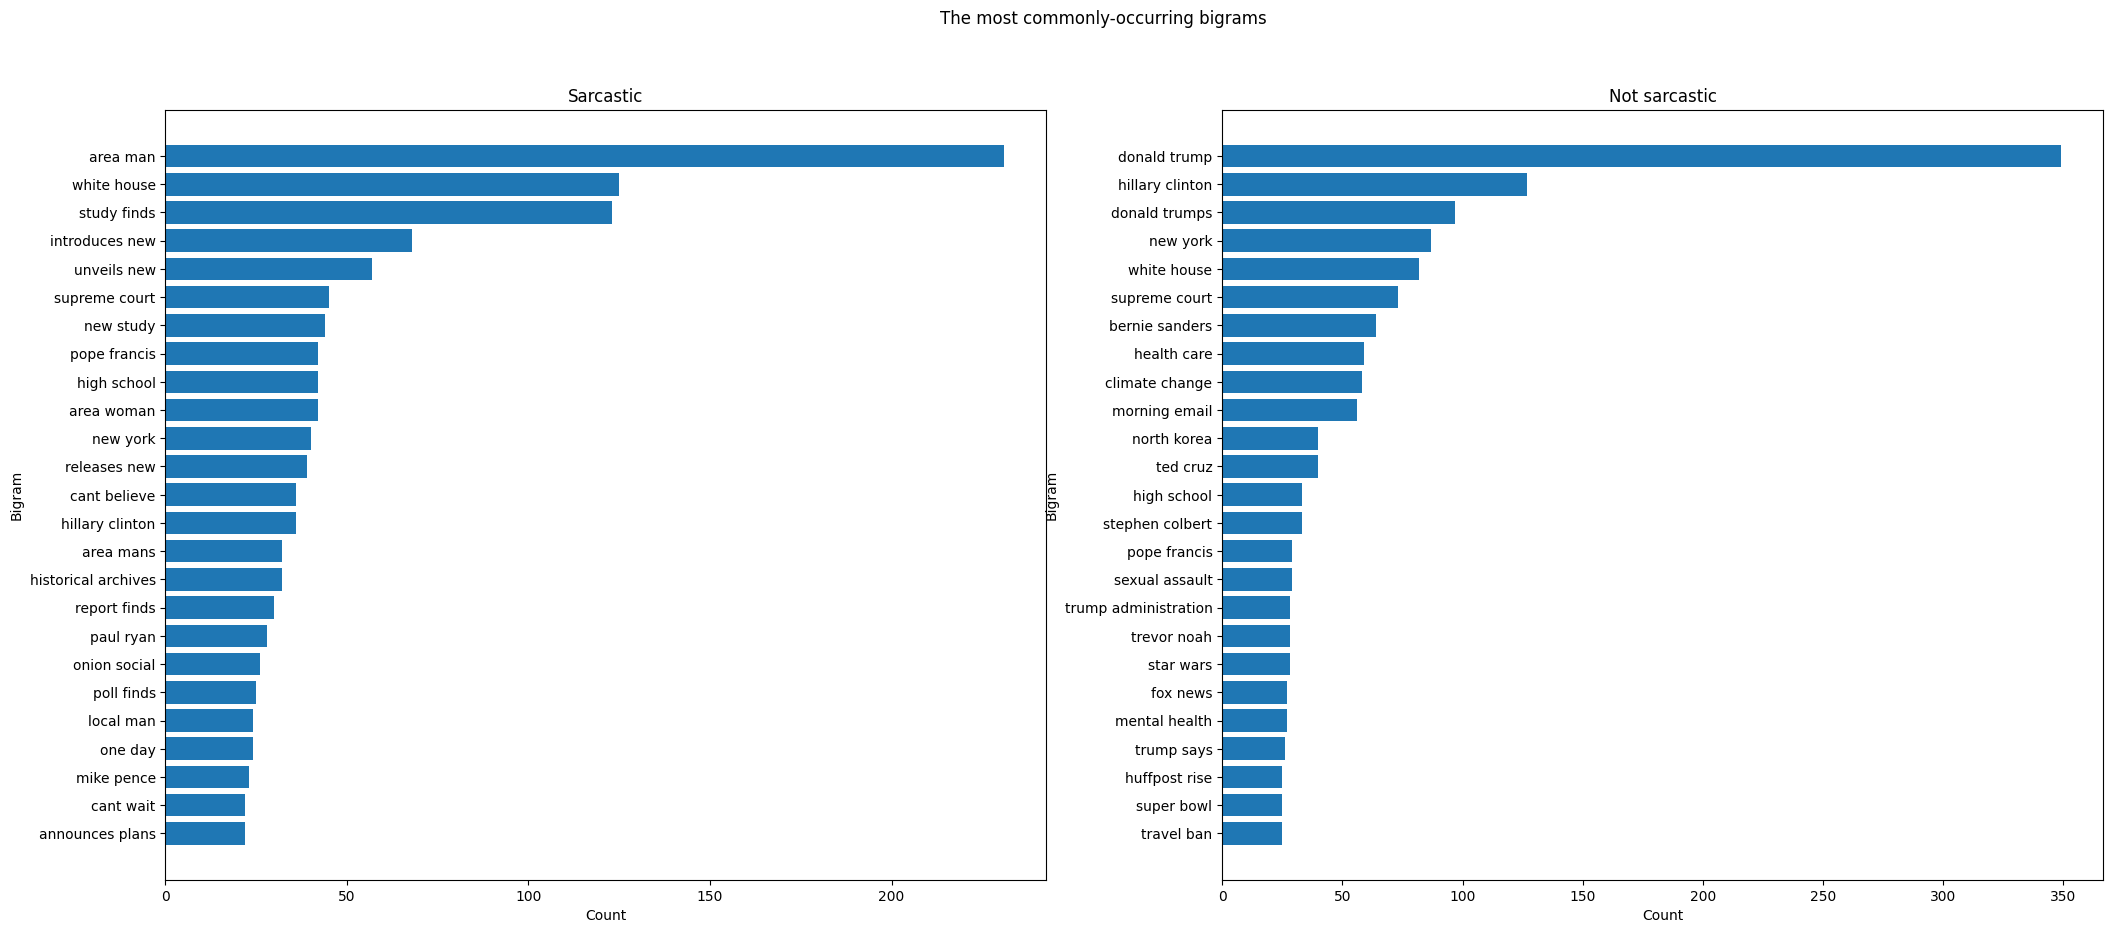

In [80]:
# the most commonly-occurring bigrams, broken down by label
common_bigram_1 = bigram_1_df[:25]
common_bigram_0 = bigram_0_df[:25]
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(25)
axs[0].barh(common_bigram_1['bigram'], common_bigram_1['count']) # positive
axs[0].invert_yaxis()
axs[0].set_xlabel("Count")
axs[0].set_ylabel("Bigram")
axs[1].barh(common_bigram_0['bigram'], common_bigram_0['count']) # negative
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")
axs[1].set_ylabel("Bigram")
fig.suptitle("The most commonly-occurring bigrams")
axs[0].title.set_text('Sarcastic')
axs[1].title.set_text('Not sarcastic')
plt.show()

## Sentiment analysis of words

In [81]:
def sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

In [82]:
# Sentiment of all words
sid_obj = SentimentIntensityAnalyzer()
all_words_df = pd.DataFrame({'word': all_words})
all_words_df['sentiment_score'] = all_words_df['word'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
all_words_df['sentiment'] = all_words_df['sentiment_score'].apply(lambda x: sentiment(x))

In [ ]:
# Sentiment of words broken by is_sarcastic
words_1_df = pd.DataFrame({'word': words_1})
words_1_df['sentiment_score'] = words_1_df['word'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
words_1_df['sentiment'] = words_1_df['sentiment_score'].apply(lambda x: sentiment(x))

words_0_df = pd.DataFrame({'word': words_0})
words_0_df['sentiment_score'] = words_0_df['word'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
words_0_df['sentiment'] = words_0_df['sentiment_score'].apply(lambda x: sentiment(x))

In [84]:
# generate wordcloud based on sentiment
def generate_wordcloud(df, n_gram = "word", n = 60):
    # Word frequencies broken by sentiment
    count_positive = Counter(df[df['sentiment'] == 'positive'][n_gram])
    count_negative = Counter(df[df['sentiment'] == 'negative'][n_gram])
    count_positive_df = pd.DataFrame(count_positive.items(), columns = [n_gram, 'count'])
    count_negative_df = pd.DataFrame(count_negative.items(), columns = [n_gram, 'count'])
    # Differentiate by color
    count_positive_df['color'] = 'red'
    count_negative_df['color'] = 'blue'
    # Most common words
    common_positive_df = count_positive_df.nlargest(n, 'count')
    common_negative_df = count_negative_df.nlargest(n, 'count')
    # Combine dataframes; create dictionaries for frequency and color
    common_df = pd.concat([common_positive_df, common_negative_df])
    common_df_freq = dict(zip(common_df[n_gram], common_df['count']))
    common_df_color = dict(zip(common_df[n_gram], common_df['color']))
    wordcloud = WordCloud(width=800, height=800, 
                      background_color="white",
                      min_font_size = 10).generate_from_frequencies(common_df_freq)
    return wordcloud, common_df_color

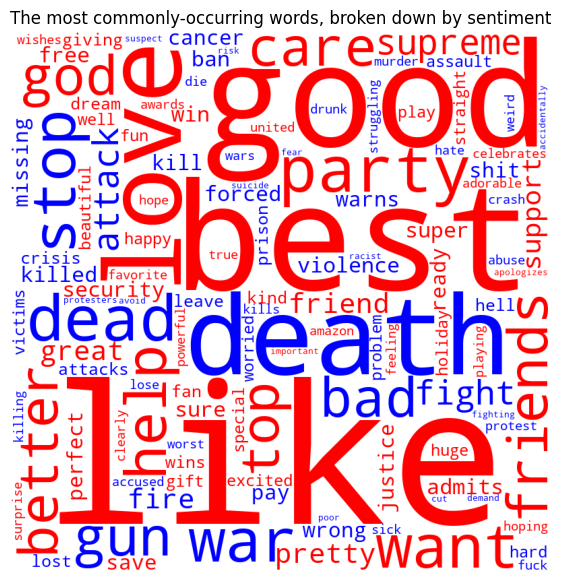

In [85]:
all_words_wc, all_words_color = generate_wordcloud(all_words_df)
plt.figure(figsize=(7, 7))
plt.imshow(all_words_wc.recolor(color_func=lambda word, **kwargs: all_words_color[word]))
plt.axis("off")
plt.title("The most commonly-occurring words, broken down by sentiment")
plt.show()

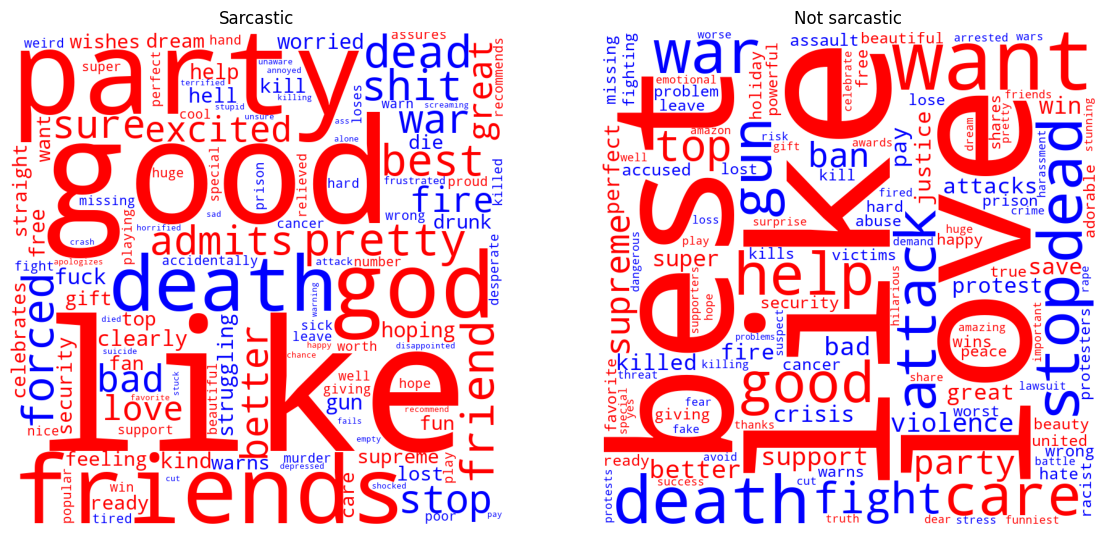

In [86]:
words_1_wc, words_1_color = generate_wordcloud(words_1_df)
words_0_wc, words_0_color = generate_wordcloud(words_0_df)
fig, axs = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(14)
axs[0].imshow(words_1_wc.recolor(color_func=lambda word, **kwargs: words_1_color[word]))
axs[1].imshow(words_0_wc.recolor(color_func=lambda word, **kwargs: words_0_color[word]))
axs[0].title.set_text('Sarcastic')
axs[1].title.set_text('Not sarcastic')
axs[0].axis("off")
axs[1].axis("off")
plt.show()

There is no clear pattern showing that sentiment differs based on if the headline is sarcastic.

## Feature Extraction

In [43]:
review = []
for index, row in df.iterrows():
    text = " ".join(row['word'])
    review.append(text)
tfidf = TfidfVectorizer()
result = tfidf.fit_transform(review)

tfidf_df = pd.DataFrame({'word': tfidf.get_feature_names_out(), 'tf-idf': tfidf.idf_})
tfidf_df = tfidf_df.sort_values(by = 'tf-idf')

In [55]:
# the 15 words with the largest tf-idf values
tfidf_df[-15:]

,word,tf-idf
13457,individualized,10.568644
13456,individuality,10.568644
13454,indistinct,10.568644
13453,indispensable,10.568644
13452,indiscrimination,10.568644
13451,indiscriminately,10.568644
13450,indiscretion,10.568644
13449,indirectly,10.568644
13448,indira,10.568644
13447,indigo,10.568644


In [56]:
# the 15 words with the smallest tf-idf values
tfidf_df[:15]

,word,tf-idf
17831,new,3.852655
27141,trump,4.034129
16016,man,4.039955
21940,report,4.856563
27893,us,4.874912
18521,one,4.950056
29041,woman,5.039215
2001,area,5.059256
23011,says,5.077642
8154,donald,5.098476


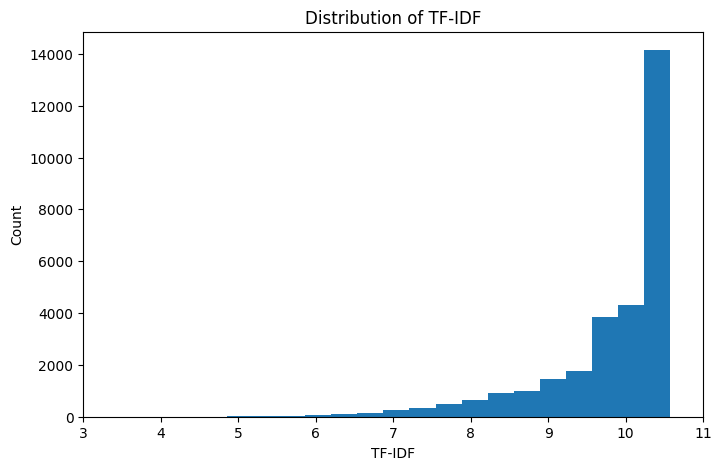

In [57]:
plt.figure(figsize=(8, 5))
plt.hist(tfidf_df['tf-idf'], bins = 20)
plt.xlabel('TF-IDF')
plt.ylabel('Count')
plt.title('Distribution of TF-IDF')
plt.xlim(3, 11)
plt.show()